<a href="https://colab.research.google.com/github/Vibha-Murthy/ITC_Internship/blob/main/Segmentation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import Image
%matplotlib inline

In [ ]:
!wget https://resources.mpi-inf.mpg.de/conference/dagm/2007/Class1_def.zip
!unzip -q Class1_def.zip -d .

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [ ]:
data_dir = "./Class1_def"

In [ ]:
!pip install xmltodict

In [ ]:
import matplotlib.image as mpimg

import glob
import os
import xmltodict
import numpy as np
import cv2
import json

In [ ]:
def get_coordinates(path_to_label, xml):
    """
    """
    with open(path_to_label, encoding='utf-8') as f:
        if xml:
            label_xml = xmltodict.parse(f.read())

            # print(type(label_xml))
            # print(label_xml)

            coordinates_object = label_xml['annotation']['object']
        else:
            label_txt = f.read()
            coordinates_object = label_txt.strip().split('\n')

    return coordinates_object


def load_coordinates(path_to_coor):
    '''
    '''

    coord_dict = {}
    coord_dict_all = {}
    with open(path_to_coor) as f:
        coordinates = f.read().split('\n')
        for coord in coordinates:
            # print(len(coord.split('\t')))
            if len(coord.split('\t')) == 6:
                coord_dict = {}
                coord_split = coord.split('\t')
                # print(coord_split)
                # print('\n')
                coord_dict['major_axis'] = round(float(coord_split[1]))
                coord_dict['minor_axis'] = round(float(coord_split[2]))
                coord_dict['angle'] = float(coord_split[3])
                coord_dict['x'] = round(float(coord_split[4]))
                coord_dict['y'] = round(float(coord_split[5]))
                index = int(coord_split[0]) - 1
                coord_dict_all[index] = coord_dict

    return coord_dict_all


In [ ]:
def get_mask_seg_ellipse(path_to_img):
    """
    """

    # get the image

    img = mpimg.imread(path_to_img)
    basename = os.path.basename(path_to_img)

    # filename_index, e.g. filename = 1.png
    # filename_index = 1, for extracting coordinates
    filename_index = int(os.path.splitext(basename)[0]) - 1
    # print(filename_index)

    path_to_coordinates = path_to_img.replace(basename, 'labels.txt')
    coordinates = load_coordinates(path_to_coordinates)

    mask = np.zeros_like(img)
    mask = cv2.ellipse(mask, 
                       (int(coordinates[filename_index]['x']), int(coordinates[filename_index]['y'])),
                       (int(coordinates[filename_index]['major_axis']), int(coordinates[filename_index]['minor_axis'])),
                       (coordinates[filename_index]['angle'] / 4.7) * 270,
                       0, 
                       360, 
                       (255, 255, 255), 
                       -1)

    mask[mask > 0] = 1.

    # print(coordinates[filename_index]['angle'])

    return mask

In [ ]:
def plot_ellipse_seg_test(path_to_img):

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)

    plt.imshow(mpimg.imread(path_to_img), cmap='gray')
    plt.subplot(1, 2, 2)
    mask = get_mask_seg_ellipse(path_to_img)
    plt.imshow(mask, cmap='gray')

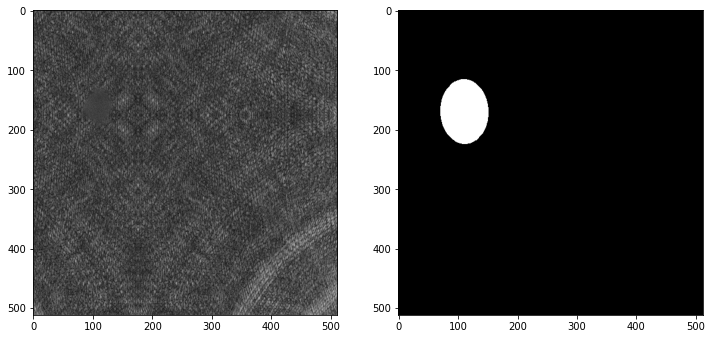

In [ ]:
plot_ellipse_seg_test(os.path.join(data_dir, "3.png"))

In [ ]:
def get_mask_seg(path_to_img, xml=True):
    '''create image for segmentation application
    Arg:
        img (numpy array): original grayscale or color rgb image
        coord_min (tuple): (xmin, ymin)
        coord_max (tuple): (xmax, ymax)
    Return:
    Notes:
    '''

    img = mpimg.imread(path_to_img)

    img_mask = np.zeros_like(img[:, :])

    if xml:
        path_to_xml = path_to_img.replace('bmp', 'xml')
        # print('path_to_xml: {}'.format(path_to_xml))
        coor_obj = get_coordinates(path_to_xml, xml)

        # if there are more than 1 bounding boxes
        if type(coor_obj) is list:
            for i in range(len(coor_obj)):
                xmin = int(coor_obj[i]['bndbox']['xmin'])
                ymin = int(coor_obj[i]['bndbox']['ymin'])
                xmax = int(coor_obj[i]['bndbox']['xmax'])
                ymax = int(coor_obj[i]['bndbox']['ymax'])

                img_mask[ymin:ymax, xmin:xmax] = 1.
        else:
            # there is only one bounding box
            # print('test')
            xmin = int(coor_obj['bndbox']['xmin'])
            ymin = int(coor_obj['bndbox']['ymin'])
            xmax = int(coor_obj['bndbox']['xmax'])
            ymax = int(coor_obj['bndbox']['ymax'])

            img_mask[ymin:ymax, xmin:xmax] = 1.

    return img_mask


def get_mask_seg_ellipse(path_to_img):
    """
    """

    # get the image

    img = mpimg.imread(path_to_img)
    basename = os.path.basename(path_to_img)

    # filename_index, e.g. filename = 1.png
    # filename_index = 1, for extracting coordinates
    filename_index = int(os.path.splitext(basename)[0]) - 1
    # print(filename_index)

    path_to_coordinates = path_to_img.replace(basename, 'labels.txt')
    coordinates = load_coordinates(path_to_coordinates)

    mask = np.zeros_like(img)
    mask = cv2.ellipse(mask, 
                       (int(coordinates[filename_index]['x']), int(coordinates[filename_index]['y'])),
                       (int(coordinates[filename_index]['major_axis']), int(coordinates[filename_index]['minor_axis'])),
                       (coordinates[filename_index]['angle'] / 4.7) * 270,
                       0, 
                       360, 
                       (255, 255, 255), 
                       -1)

    mask[mask > 0] = 1.

    # print(coordinates[filename_index]['angle'])

    return mask

In [ ]:
IMAGE_CHANNELS = 1

def load_images_masks(path_to_images, img_type, img_format, resize, ellipse=False):

    if not ellipse:
        image_names = [x for x in os.listdir(path_to_images) if x.endswith('.xml')]
    else:
        image_names = [x for x in os.listdir(path_to_images) if x.endswith(img_type)]

    image_num = len(image_names)
    images_all = np.empty([image_num, resize[0], resize[1], IMAGE_CHANNELS])
    labels_all = np.empty([image_num, resize[0], resize[1], IMAGE_CHANNELS])

    if not ellipse:
        image_names = [x.replace('xml', img_type) for x in image_names]

    for image_index in range(image_num):
        image_filename = image_names[image_index]
        # print(image_filename)
        # print(image_filename)
        image = mpimg.imread(os.path.join(path_to_images, image_filename), format=img_format)
        if ellipse:
            mask = get_mask_seg_ellipse(os.path.join(path_to_images, image_filename))
        else:
            mask = get_mask_seg(os.path.join(path_to_images, image_filename))

        if resize:
            image = cv2.resize(image, (resize[0], resize[1]))
            mask = cv2.resize(mask, (resize[0], resize[1]))

        images_all[image_index] = np.reshape(image, (resize[0], resize[1], IMAGE_CHANNELS))
        labels_all[image_index] = np.reshape(mask, (resize[0], resize[1], IMAGE_CHANNELS))

    return images_all, labels_all


In [ ]:
X, y = load_images_masks(data_dir, img_type='png', img_format='gray', resize=(512, 512), ellipse=True)

In [ ]:
X.shape

(150, 512, 512, 1)

In [ ]:
y.shape

(150, 512, 512, 1)

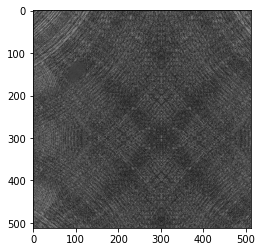

In [ ]:
plt.imshow(X[0,:,:,0], cmap='gray')

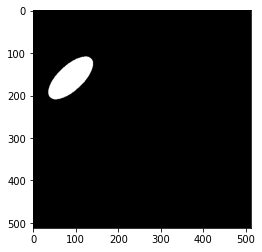

In [ ]:
plt.imshow(y[0,:,:,0], cmap='gray')

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
X_train.shape

(105, 512, 512, 1)

In [ ]:
X_test.shape

(45, 512, 512, 1)

In [ ]:
img_rows = 512
img_cols = 512

In [ ]:
import tensorflow as tf
from tensorflow import keras as keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Conv2DTranspose, concatenate
from keras.optimizers import adam_v2
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from scipy.ndimage.measurements import label
import time

In [ ]:
# Defining a small Unet
# Smaller Unet defined so it fits in memory


def get_small_unet():
    inputs = Input((img_rows, img_cols, 1))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(16, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(8, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    df_model = Model(inputs=inputs, outputs=conv10)

    return df_model

In [ ]:
defect_model = get_small_unet()

In [ ]:
def smooth_dice_coeff(smooth=1.):

    smooth = float(smooth)

    # IOU or dice coeff calculation
    def IOU_calc(y_true, y_pred):
            y_true_f = K.flatten(y_true)
            y_pred_f = K.flatten(y_pred)
            intersection = K.sum(y_true_f * y_pred_f)

            return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def IOU_calc_loss(y_true, y_pred):
        return -IOU_calc(y_true, y_pred)
    return IOU_calc, IOU_calc_loss

IOU_calc, IOU_calc_loss = smooth_dice_coeff(0.00001)

In [ ]:
defect_model.compile(optimizer=adam_v2(lr=1e-4), loss=IOU_calc_loss, metrics=[IOU_calc])

TypeError: ignored